In [202]:
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.util.utils import get_agg_features

from hurst_exponent.util.utils import augmented_dickey_fuller

In [203]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
# Number of events to use
EVENTS_RANGE = 500000

# Lag/window size for Hurst and the ACF
LAG = 100

## Load raw sample data

In [205]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [206]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,trade_sign,side,lob_action,order_executed,execution_price,execution_size,ask,bid,midprice,ask_volume,bid_volume,price_changing,midprice_change,R1,norm_trade_volume
0,0,2016-01-04 10:30:02.487834868,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
1,1,2016-01-04 10:30:02.594369706,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
2,2,2016-01-04 10:30:02.602151380,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,200.0,100.0,True,-0.095,0.095,0.708122
3,3,2016-01-04 10:30:02.627167275,-1,BID,REMOVE,True,221.27,25,221.36,221.27,221.315,200.0,25.0,True,-0.010,0.010,0.177031
4,4,2016-01-04 10:30:02.895123534,-1,BID,REMOVE,True,221.25,100,221.36,221.25,221.305,100.0,100.0,True,-0.090,0.090,0.708122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757587,757587,2016-12-30 14:57:34.003070849,-1,BID,REMOVE,True,212.66,78,212.71,212.66,212.685,100.0,78.0,True,-0.045,0.045,0.523301
757588,757588,2016-12-30 14:57:49.675498708,1,ASK,REMOVE,True,212.70,100,212.70,212.58,212.640,100.0,3.0,True,0.015,0.015,0.764442
757589,757589,2016-12-30 14:57:50.825570371,1,ASK,REMOVE,True,212.73,118,212.73,212.58,212.655,118.0,3.0,True,-0.005,-0.005,0.902041
757590,757590,2016-12-30 14:58:02.190130229,1,ASK,REMOVE,True,212.72,100,212.72,212.58,212.650,100.0,3.0,True,0.035,0.035,0.764442


# The Long Memory of Orderflow (Trades)

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

## 1. Signed Orderflow

In [ ]:
# Signs
signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'],
  'MSFT': msft_raw_df['trade_sign'],
  'AMZN': amzn_raw_df['trade_sign'],
  'NFLX': nflx_raw_df['trade_sign'],
  'EBAY': ebay_raw_df['trade_sign'],
  'APPL': appl_raw_df['trade_sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in signed_orderflow.items()}

### Stationarity Test

In [208]:
# ADF test
for stock, data in signed_orderflow.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -54.44
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -63.99
p-value: 0.00,
N: 499913, 
critical values: {'1%': -3.4303630809432404, '5%': -2.861545781622942, '10%': -2.566773077346696}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -53.27
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -55.65
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 1.1. Signs ACF

In [209]:
# Linear ACF
signs_linear_acf_filename = f"{acf_data_dir}/mo_signs_acfs.pkl"
signs_linear_acfs = compute_acfs(filename=signs_linear_acf_filename, data=signed_orderflow, option='linear')
print(signs_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [210]:
# Nonlinear ACF
signs_nonlinear_acf_filename = f"{acf_data_dir}/mo_signs_nonlinear_acfs.pkl"
signs_nonlinear_acfs = compute_acfs(filename=signs_nonlinear_acf_filename, data=signed_orderflow, option='nonlinear')
print(signs_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


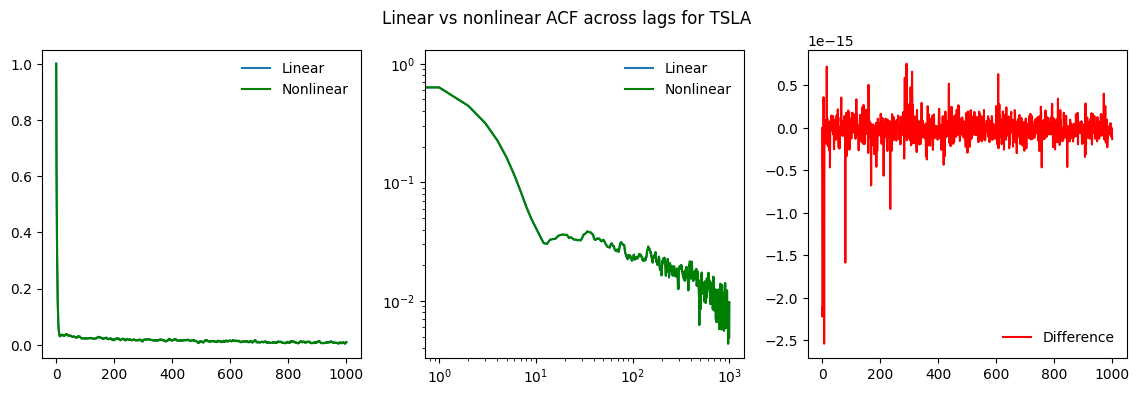

TSLA Max difference: 7.563394355258879e-16


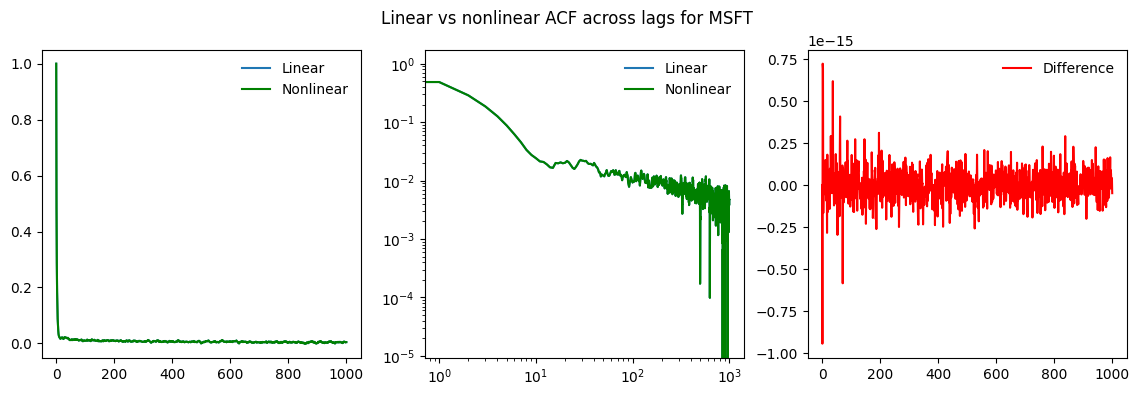

MSFT Max difference: 7.216449660063518e-16


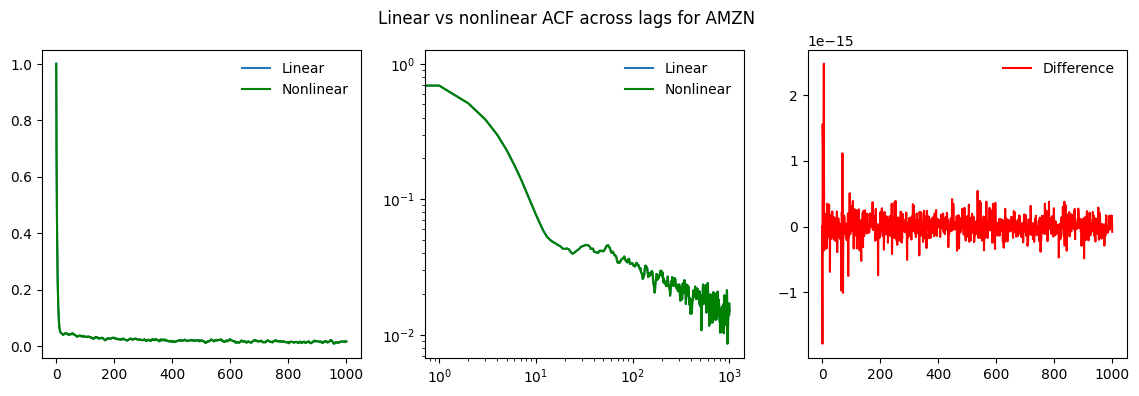

AMZN Max difference: 2.4702462297909733e-15


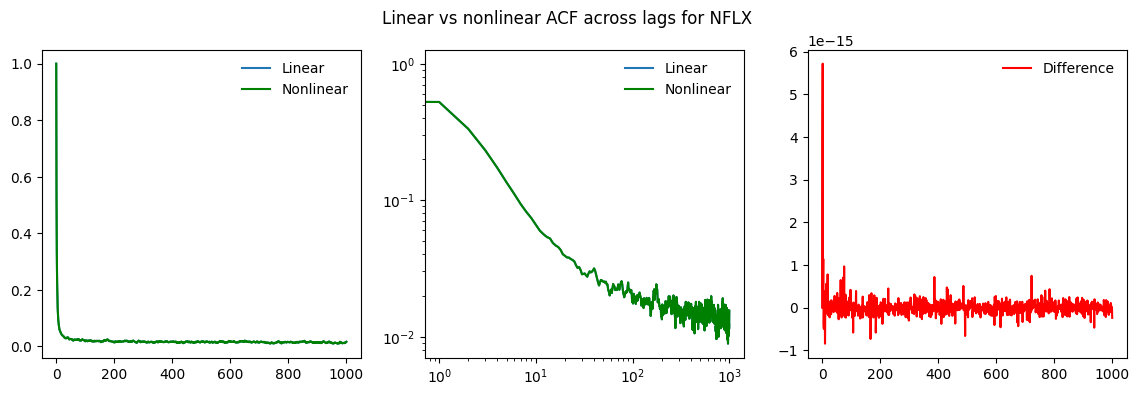

NFLX Max difference: 5.717648576819556e-15


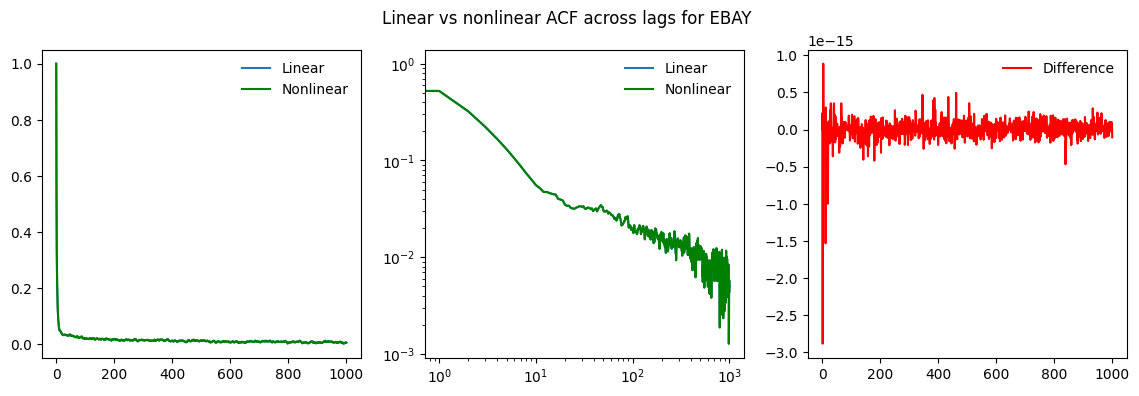

EBAY Max difference: 8.881784197001252e-16


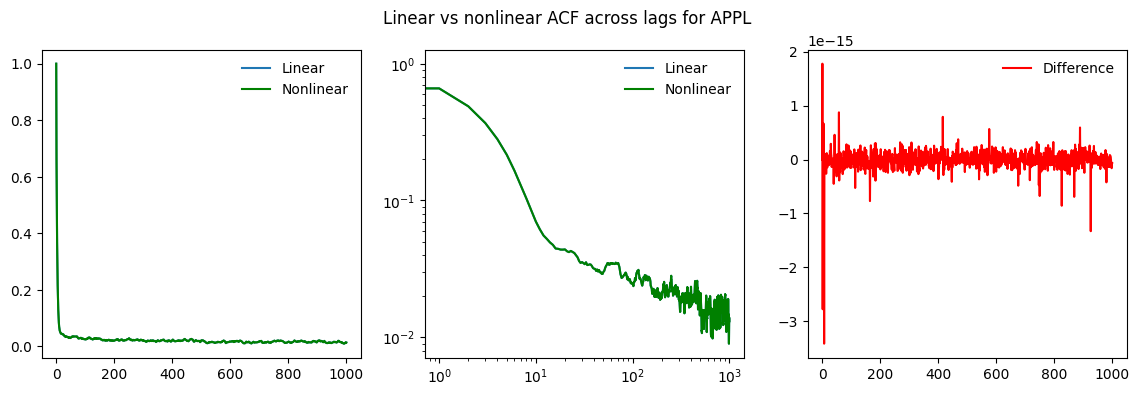

APPL Max difference: 1.7763568394002505e-15


In [211]:
for stock_name in signs_linear_acfs.keys():
    plot_acf_difference(stock_name, signs_linear_acfs, signs_nonlinear_acfs)

### 1.2. Fit power law to ACF

In [212]:
# Load the pre-computed ACFs
signs_acf_values = {}

for stock, data in signs_nonlinear_acfs.items():
    signs_acf_values[stock] = construct_xy(data, stock)

In [213]:
# Using signs_nonlinear_acfs
signs_fit_results_list = []
signs_fit_objects = {}  # Dictionary to store fit objects

for stock, data in signs_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[stock] = fit_obj  # Store the fit object

signs_acf_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.0640212...",387,388.0,0.175896,-7556.374606,16.461396,0.628029,-0.863071,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0993726...",5,6.0,0.196787,-11832.429691,80.685454,0.741886,-0.462292,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1666578...",7,8.0,0.151911,-11105.286462,10.926830,0.853037,-0.354850,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0678528...",16,17.0,0.116751,-12060.216094,10.733763,0.742381,-0.246273,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2080714...",5,6.0,0.173695,-11590.352362,20.101214,0.897656,-0.494715,EBAY


In [214]:
signs_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [215]:
avg_alpha = signs_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.4552095939089971


### 1.3. Signed Orderflow Hurst Exponents

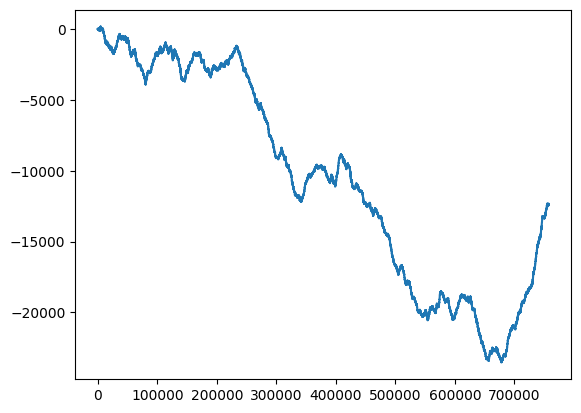

In [216]:
# Compute cumsum of signed orderflow
cumsum_signed_orderflow = {
  'TSLA': tsla_raw_df['trade_sign'].cumsum(),
  'MSFT': msft_raw_df['trade_sign'].cumsum(),
  'AMZN': amzn_raw_df['trade_sign'].cumsum(),
  'NFLX': nflx_raw_df['trade_sign'].cumsum(),
  'EBAY': ebay_raw_df['trade_sign'].cumsum(),
  'APPL': appl_raw_df['trade_sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_signed_orderflow.items()}
tsla_cumsum_signs = tsla_raw_df['trade_sign'].cumsum()
x = list(range(1, len(tsla_cumsum_signs)+1))
plt.plot(x, tsla_cumsum_signs)
plt.grid(False)

#### Standard Hurst

In [217]:
# Standard Hurst
method = 'standard'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_std_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3134843...",19,3.0,0.021152,-3966.629787,0.705348,0.999811,0.665866,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2585199...",26,3.0,0.010744,-6425.950744,0.572100,0.999863,0.642851,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3897534...",32,4.0,0.020513,-4124.030771,0.720415,0.999747,0.672227,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1615054...",1,1.0,0.020376,-6959.493394,0.686012,0.999896,0.663951,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1931968...",1,1.0,0.019444,-3361.256663,0.888829,0.999801,0.671436,EBAY,signs
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4753102...",97,9.0,0.010999,-6463.503177,0.257436,0.999936,0.646010,APPL,signs


In [218]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = signs_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6603900561033582


#### Generalized Hurst

In [219]:
# Generalized Hurst
method = 'generalized'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_gen_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0052926...",361,42.0,0.017682,-3732.455354,0.120797,0.999926,0.678283,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0779189...",1,1.0,0.020243,-6261.947975,0.915992,0.999736,0.625471,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2263986...",1,1.0,0.020875,-3877.656839,1.465877,0.999475,0.651388,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9962649...",1,1.0,0.010188,-7013.408327,0.710798,0.999838,0.646784,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0369962...",1,1.0,0.020833,-3347.446675,1.002458,0.999659,0.648322,EBAY,signs


In [220]:
# Generalized Hurst statistic across stocks
min_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = signs_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.6254709260771547
Max Generalized Hurst: 0.6782829937793351
Average Generalized Hurst: 0.6463580047385694
Standard_dev Generalized Hurst: 0.019107549377317


## 2. Size/ Volume

In [221]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_trade_volume'],
               'MSFT': amzn_raw_df['norm_trade_volume'],
               'AMZN': nflx_raw_df['norm_trade_volume'],
               'NFLX': msft_raw_df['norm_trade_volume'],
               'EBAY': ebay_raw_df['norm_trade_volume'],
               'APPL': appl_raw_df['norm_trade_volume'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [223]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -56.98
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.80
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -74.32
p-value: 0.00,
N: 499928, 
critical values: {'1%': -3.4303630805507535, '5%': -2.861545781449468, '10%': -2.5667730772543624}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -52.22
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 2.1. Size/volume ACF

In [224]:
# Linear ACF
volume_linear_acf_filename = f"{acf_data_dir}/mo_volume_linear_acfs.pkl"
volume_linear_acfs = compute_acfs(filename=volume_linear_acf_filename, data=size_volume, option='linear')
print(volume_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [225]:
# Nonlinear ACF
volume_nonlinear_acf_filename = f"{acf_data_dir}/mo_volume_nonlinear_acfs.pkl"
volume_nonlinear_acfs = compute_acfs(filename=volume_nonlinear_acf_filename, data=size_volume, option='nonlinear')
print(volume_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


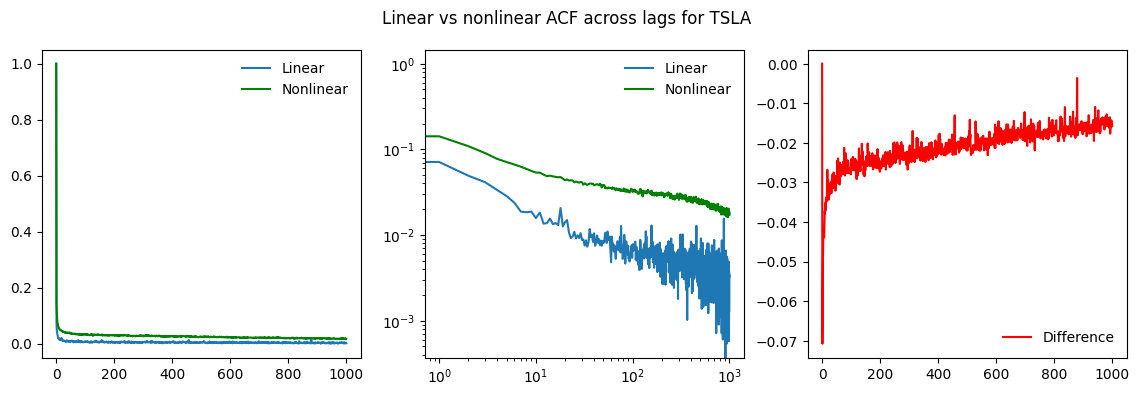

TSLA Max difference: 0.0


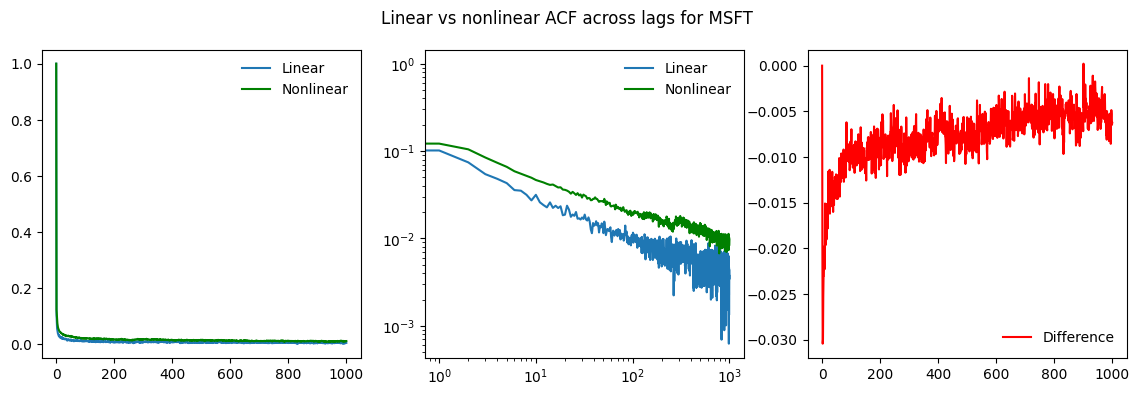

MSFT Max difference: 0.00021827006601764926


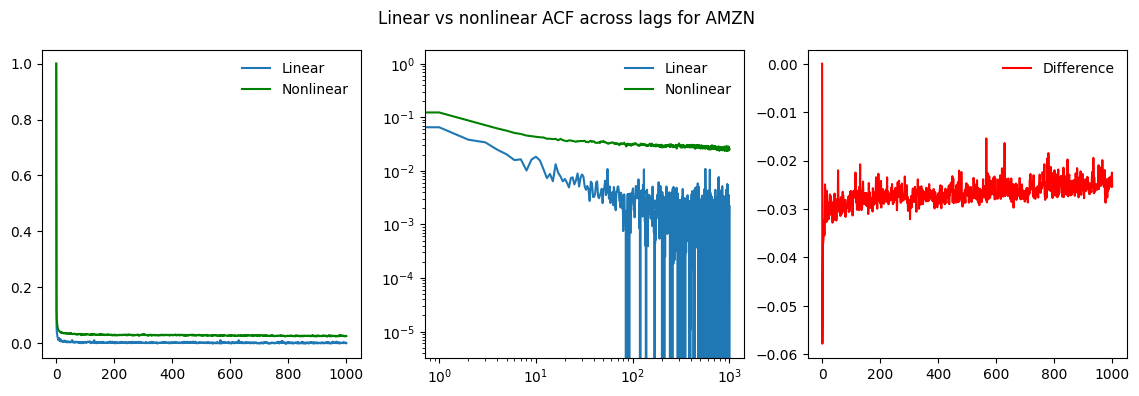

AMZN Max difference: 1.1102230246251565e-16


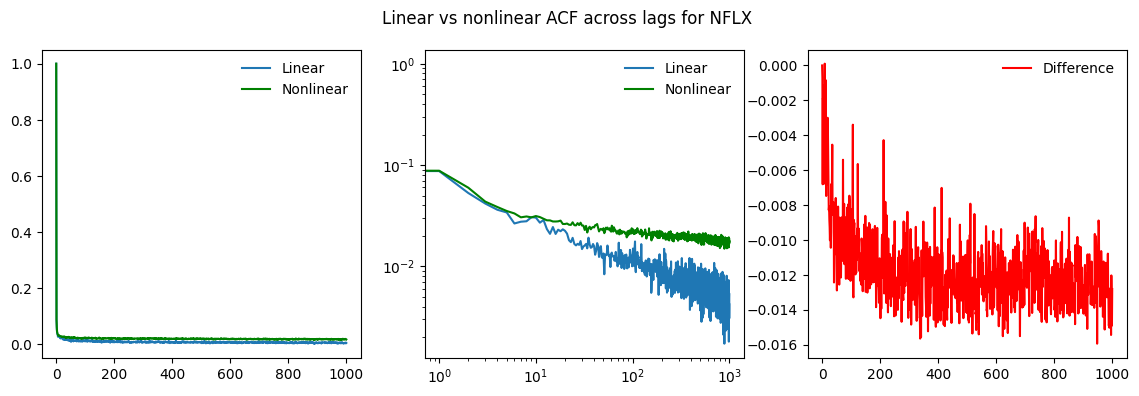

NFLX Max difference: 0.00010090948994299909


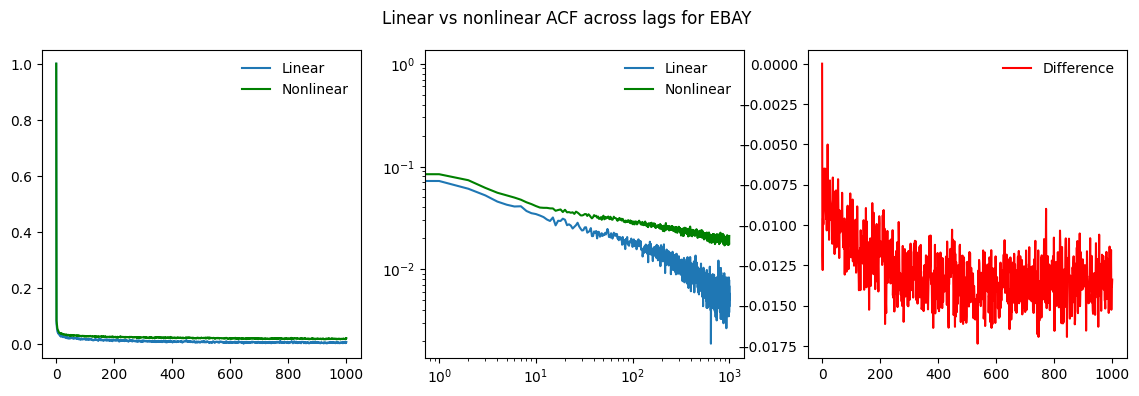

EBAY Max difference: 0.0


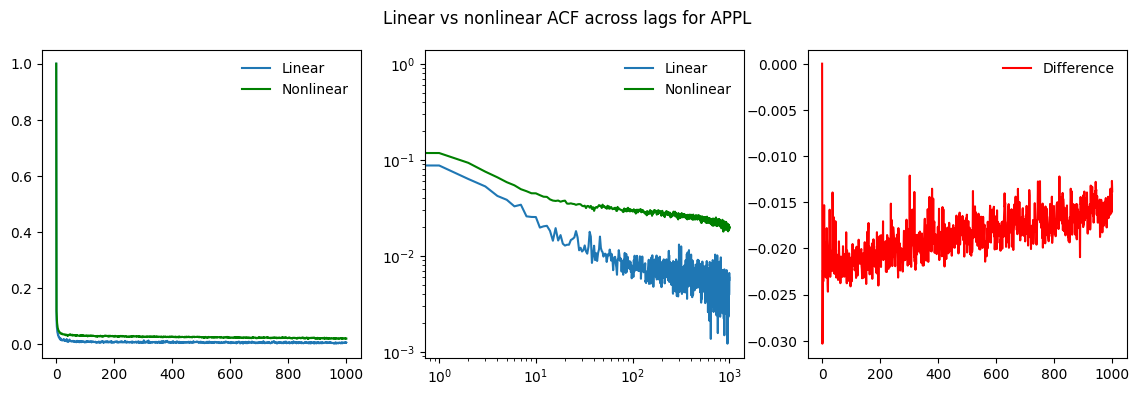

APPL Max difference: 0.0


In [226]:
for stock_name in volume_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_linear_acfs, volume_nonlinear_acfs)

### 2.2. Fit power law to ACF

In [227]:
# Load the pre-computed ACFs
volume_acf_values = {}

for stock, data in volume_nonlinear_acfs.items():
    volume_acf_values[stock] = construct_xy(data, stock)

In [316]:
# Using volume_nonlinear_acfs
volume_fit_results_list = []
volume_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[stock] = fit_obj  # Store the fit object

volume_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.4049101...",430,431.0,0.087566,-8041.465131,3.271661,0.881032,-0.449751,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2674580...",298,299.0,0.092461,-9766.624542,6.935165,0.810464,-0.492506,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0517547...",4,5.0,0.106319,-13167.329642,3.084048,0.820414,-0.101689,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0375591...",3,4.0,0.113226,-13576.099530,4.203500,0.801308,-0.112093,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0683973...",2,3.0,0.105105,-13371.298497,3.582612,0.938512,-0.184864,EBAY


In [317]:
volume_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [318]:
avg_alpha = volume_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.26652695947288124


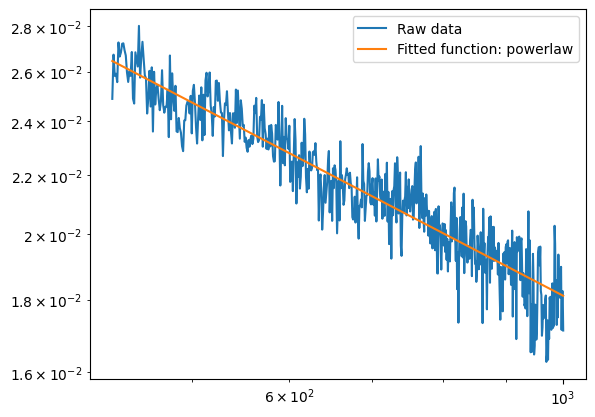

In [319]:
tsla_acf_fit = volume_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3. Size/ Volume Hurst Exponents

In [ ]:
# Compute cumsum of size/volumes
cumsum_size_volume = {
               'TSLA': tsla_raw_df['norm_trade_volume'].cumsum(),
               'MSFT': amzn_raw_df['norm_trade_volume'].cumsum(),
               'AMZN': nflx_raw_df['norm_trade_volume'].cumsum(),
               'NFLX': msft_raw_df['norm_trade_volume'].cumsum(),
               'EBAY': ebay_raw_df['norm_trade_volume'].cumsum(),
               'APPL': appl_raw_df['norm_trade_volume'].cumsum()
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_size_volume.items()}
tsla_cumsum_volume = amzn_raw_df['norm_trade_volume'].cumsum()
x = list(range(1, len(tsla_cumsum_volume)+1))
plt.plot(x, tsla_cumsum_volume)
plt.grid(False)
plt.show()

#### Standard Hurst

In [ ]:
# Standard Hurst
method = 'standard'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_size_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_std_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9733930...",1,1.0,0.020713,-4155.849983,1.225472,0.999608,0.634822,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.6435201...",103,11.0,0.022124,-4667.191496,0.775407,0.999570,0.701682,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9277386...",53,5.0,0.021242,-5988.123803,0.895681,0.999588,0.643506,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1733524...",101,9.0,0.022026,-8095.143342,1.027514,0.999470,0.738692,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1483419...",1,1.0,0.020833,-5050.505895,2.163874,0.999318,0.731393,EBAY,volume


In [ ]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6793620067914693


In [ ]:
display(volume_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'volume'), ('MSFT', 'standard', 'volume'), ('AMZN', 'standard', 'volume'), ('NFLX', 'standard', 'volume'), ('EBAY', 'standard', 'volume'), ('APPL', 'standard', 'volume')])

#### Generalized Hurst

In [279]:
# Generalized Hurst
method = 'generalized'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_size_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_gen_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5667526...",1,1.0,0.010357,-17745.522028,0.000413,1.0,1.000015,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5197654...",1,1.0,0.010934,-21818.495315,0.000153,1.0,0.999994,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.5058749...",1,1.0,0.010188,-29152.656510,0.000109,1.0,0.999996,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1613592...",1,1.0,0.010526,-29401.955982,0.000138,1.0,0.999999,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1446074...",1,1.0,0.011111,-17280.704335,0.000221,1.0,0.999990,EBAY,volume


In [280]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9999865609416567
Max Generalized Hurst: 1.0000150442385265
Average Generalized Hurst: 0.9999969254552998
Standard_dev Generalized Hurst: 9.97101969941871e-06


In [281]:
print(volume_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume'), ('MSFT', 'generalized', 'volume'), ('AMZN', 'generalized', 'volume'), ('NFLX', 'generalized', 'volume'), ('EBAY', 'generalized', 'volume'), ('APPL', 'generalized', 'volume')])


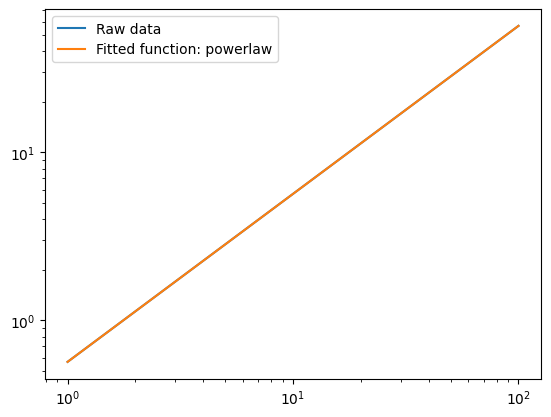

In [282]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volume_fit_objects[('TSLA', 'generalized', 'volume')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Signed Ordeflow Imbalance

In [283]:
# Aggregate orderflow
tsla_aggregate_orderflow = get_agg_features(tsla_raw_df, [LAG], remove_outliers=False)
msft_aggregate_orderflow = get_agg_features(msft_raw_df, [LAG], remove_outliers=False)
amzn_aggregate_orderflow = get_agg_features(amzn_raw_df, [LAG], remove_outliers=False)
nflx_aggregate_orderflow = get_agg_features(nflx_raw_df, [LAG],remove_outliers=False)
ebay_aggregate_orderflow = get_agg_features(ebay_raw_df, [LAG], remove_outliers=False)
appl_aggregate_orderflow = get_agg_features(appl_raw_df, [LAG],remove_outliers=False)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

#### Stationarity Test

In [284]:
# Sign imbalance ADF test
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -11.33
p-value: 0.00,
N: 7552, 
critical values: {'1%': -3.431216197578816, '5%': -2.861922794140392, '10%': -2.5669737568795616}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -15.03
p-value: 0.00,
N: 15247, 
critical values: {'1%': -3.4307789631586263, '5%': -2.8617295833846796, '10%': -2.5668709106206444}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -18.18
p-value: 0.00,
N: 10140, 
critical values: {'1%': -3.4309950647136693, '5%': -2.8618250806650556, '10%': -2.5669217432960254}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -15.57
p-value: 0.00,
N: 16290, 
critical values: {'1%': -3.4307514936002126, '5%': -2.861717443834558, '10%': -2.566864448891165}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY


In [285]:
# Volume imbalance ADF test
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -14.59
p-value: 0.00,
N: 7556, 
critical values: {'1%': -3.4312157388746796, '5%': -2.8619225914572133, '10%': -2.566973648988558}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -18.95
p-value: 0.00,
N: 15263, 
critical values: {'1%': -3.4307785134065885, '5%': -2.8617293846278415, '10%': -2.566870804824729}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -15.04
p-value: 0.00,
N: 10129, 
critical values: {'1%': -3.4309957654256156, '5%': -2.861825390304864, '10%': -2.566921908117538}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -18.28
p-value: 0.00,
N: 16289, 
critical values: {'1%': -3.430751518252241, '5%': -2.861717454729015, '10%': -2.5668644546901382}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
AD

### 3.1. Order sign imbalance long memory

In [286]:
# Linear ACF
sign_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_linear_acfs.pkl"
sign_imbalance_linear_acfs = compute_acfs(filename=sign_imbalance_linear_acf_filename, data=sign_imbalance, option='linear')
print(sign_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [287]:
# Nonlinear ACF
sign_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_nonlinear_acfs.pkl"
sign_imbalance_nonlinear_acfs = compute_acfs(filename=sign_imbalance_nonlinear_acf_filename, data=sign_imbalance, option='nonlinear')
print(sign_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


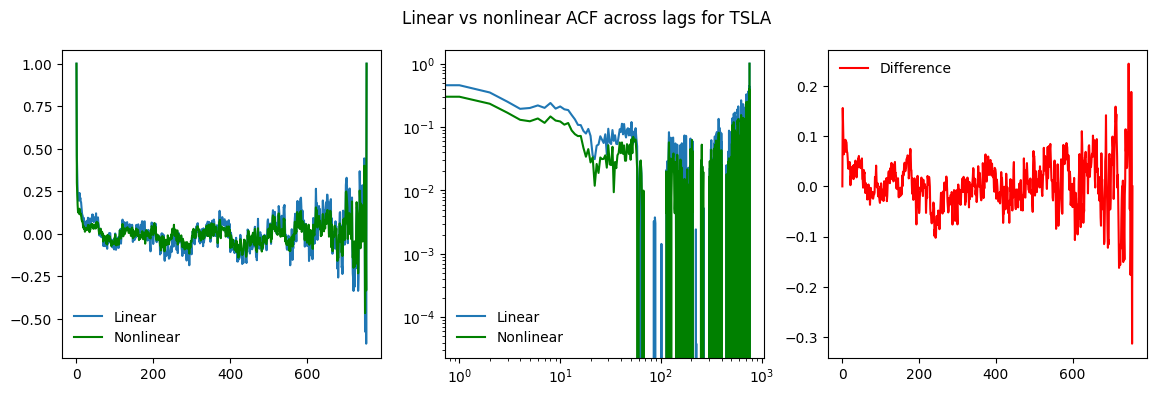

TSLA Max difference: 0.2441571170766467


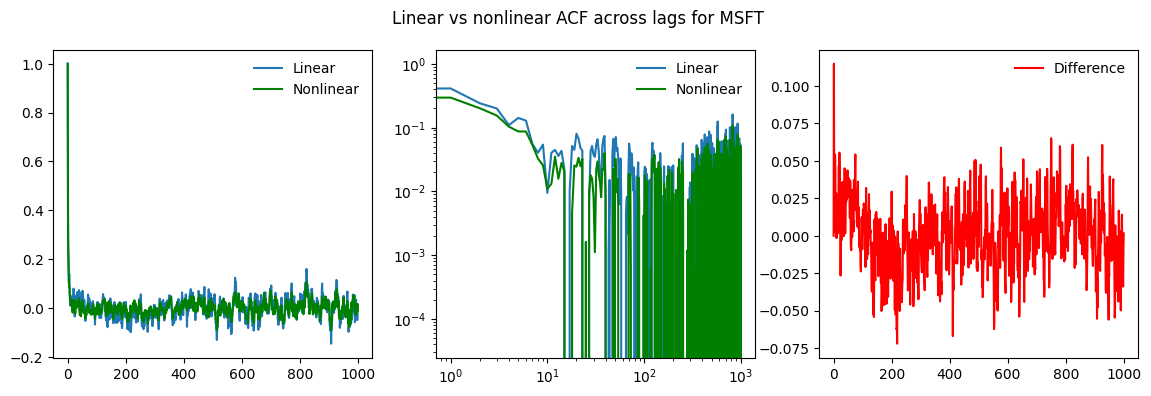

MSFT Max difference: 0.11494756016652802


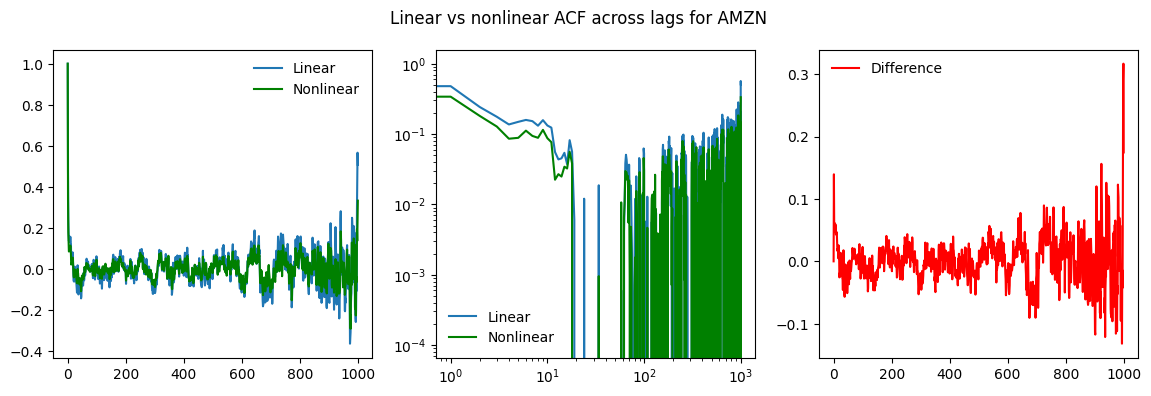

AMZN Max difference: 0.3166719250338804


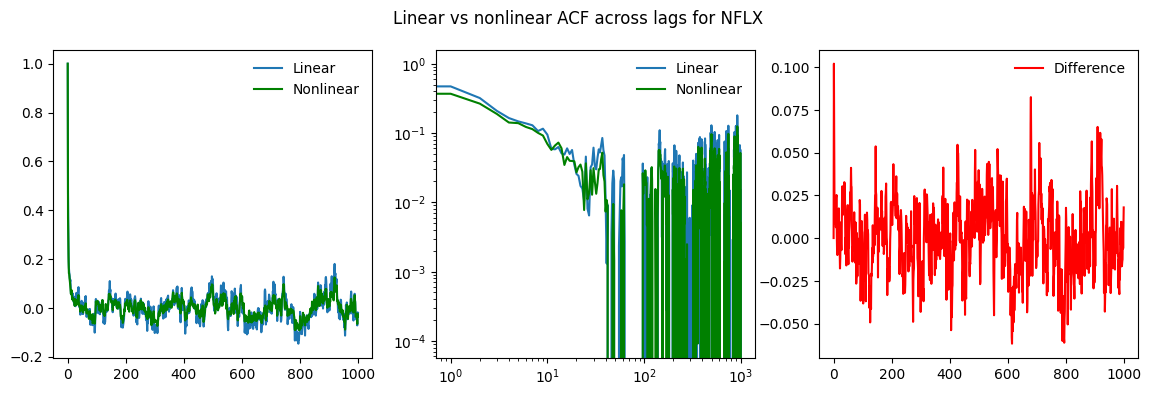

NFLX Max difference: 0.10205964050824251


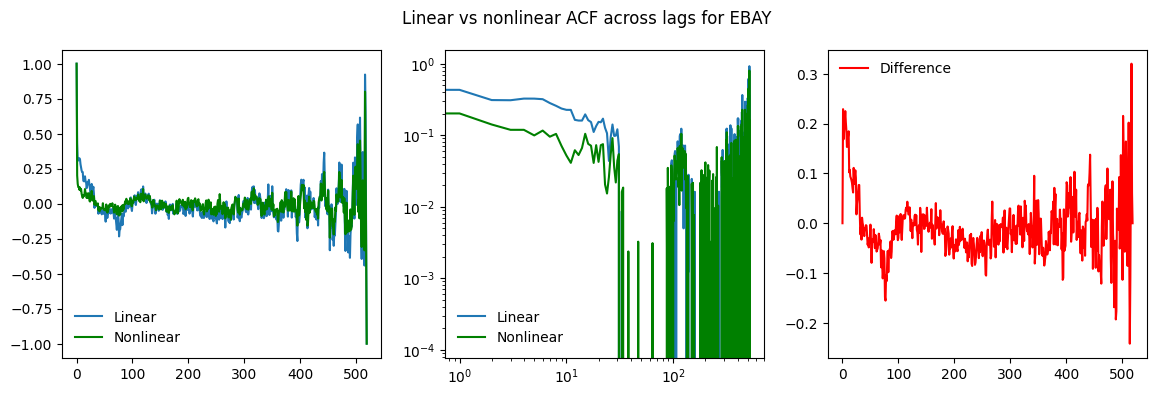

EBAY Max difference: 0.32047823489471167


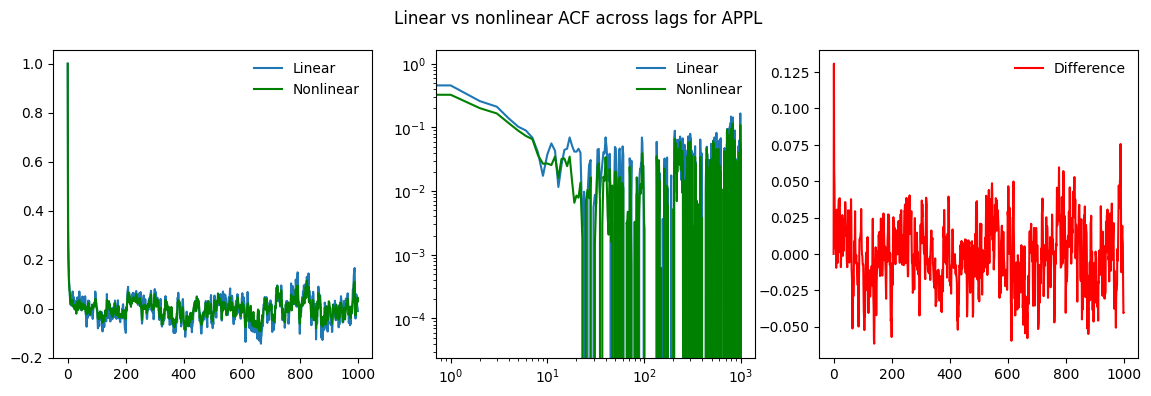

APPL Max difference: 0.13075138192001118


In [288]:
for stock_name in sign_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, sign_imbalance_linear_acfs, sign_imbalance_nonlinear_acfs)

#### 3.1.1. Fit power law to ACF

In [289]:
# Load the pre-computed ACFs
sign_imbalance_acf_values = {}

for stock, data in sign_imbalance_nonlinear_acfs.items():
    sign_imbalance_acf_values[stock] = construct_xy(data, stock)

In [290]:
# Using signs_imbalance_nonlinear_acfs
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in sign_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

sign_imbalance_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_fit_results.head())

cannot unpack non-iterable NoneType object
cannot unpack non-iterable NoneType object


/Users/ana_bugaenko/workspace/powerlaw_function/util/linear_fits.py:25: RuntimeWarning: divide by zero encountered in log
  log_y_values = np.log(y_values)
/Users/ana_bugaenko/workspace/powerlaw_function/util/supported_functions.py:25: RuntimeWarning: invalid value encountered in multiply
  return C * x**alpha
/Users/ana_bugaenko/workspace/powerlaw_function/util/linear_fits.py:25: RuntimeWarning: divide by zero encountered in log
  log_y_values = np.log(y_values)
/Users/ana_bugaenko/workspace/powerlaw_function/util/supported_functions.py:25: RuntimeWarning: invalid value encountered in multiply
  return C * x**alpha


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000890...",10,12.0,0.517426,-3818.230114,inf,-0.004043,0.000469,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.003376...",10,11.0,0.492432,-7185.437639,105.128489,-0.002681,-0.281669,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000613...",10,12.0,0.514141,-5803.878533,inf,-0.003043,0.000265,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -4.859139...",10,11.0,0.511604,-6631.918811,105.053788,-0.002548,0.479489,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000331...",10,11.0,0.484314,-2374.402739,132.288282,-0.003300,0.590078,EBAY


In [291]:
print(sign_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [292]:
avg_alpha = sign_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: 0.15493136757799364


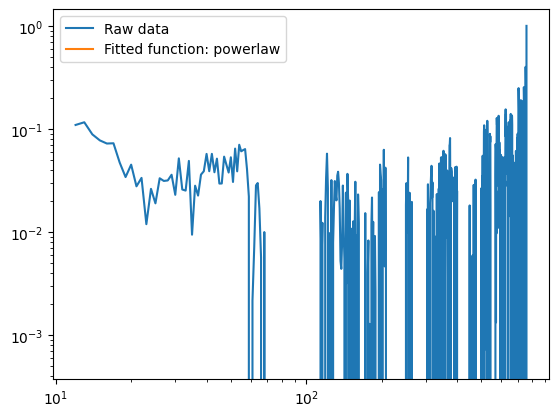

In [293]:
tsla_acf_fit = sign_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.1.2. Sign Imbalance Hurst Exponents

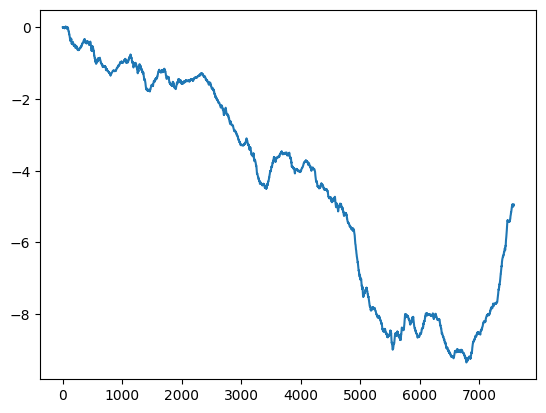

In [294]:
# Compute cumsum of order sign imbalance
cumsum_sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'].cumsum(),
  'MSFT': msft_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'].cumsum(),
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'].cumsum(),
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'].cumsum(),
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_sign_imbalance.items()}
tsla_cumsum_sign_imbalance = tsla_aggregate_orderflow['sign_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_sign_imbalance)+1))
plt.plot(x, tsla_cumsum_sign_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [295]:
# Standard Hurst
method = 'standard'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('sign_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signs_imbalance')] = fit

sign_imbalance_std_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_std_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0098389...",1,2.0,0.034884,-948.655824,1.343256,0.998489,0.782492,TSLA,sign_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0049727...",1,1.0,0.040984,-1461.816398,1.968203,0.995420,0.714461,MSFT,sign_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0085942...",1,2.0,0.020202,-1149.368913,1.708396,0.998131,0.731729,AMZN,sign_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0040222...",1,1.0,0.031746,-1656.411312,1.887632,0.998362,0.743267,NFLX,sign_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0108987...",1,2.0,0.042254,-677.676237,2.849012,0.996702,0.832562,EBAY,sign_imbalance


In [296]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = sign_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6395340232369439


##### Generalized Hurst

In [297]:
# Generalized Hurst
method = 'generalized'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('signed_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signed_imbalance')] = fit

sign_imbalance_gen_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0070438...",1,2.0,0.011628,-1252.362898,0.303842,0.999927,0.799306,TSLA,signed_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0031703...",1,1.0,0.016393,-1972.047464,0.694473,0.999877,0.747972,MSFT,signed_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0064231...",1,2.0,0.010101,-1454.966257,0.859585,0.999866,0.745198,AMZN,signed_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0029078...",1,1.0,0.015873,-2000.092192,1.056107,0.999829,0.761488,NFLX,signed_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0078705...",1,2.0,0.028169,-871.785079,2.012502,0.999429,0.799686,EBAY,signed_imbalance


In [298]:
# Generalized Hurst statistic across stocks
min_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.036259885618892096
Max Generalized Hurst: 0.7996858576189291
Average Generalized Hurst: 0.64831841274881
Standard_dev Generalized Hurst: 0.3008152257008935


In [299]:
print(sign_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'signed_imbalance'), ('MSFT', 'generalized', 'signed_imbalance'), ('AMZN', 'generalized', 'signed_imbalance'), ('NFLX', 'generalized', 'signed_imbalance'), ('EBAY', 'generalized', 'signed_imbalance'), ('APPL', 'generalized', 'signed_imbalance')])


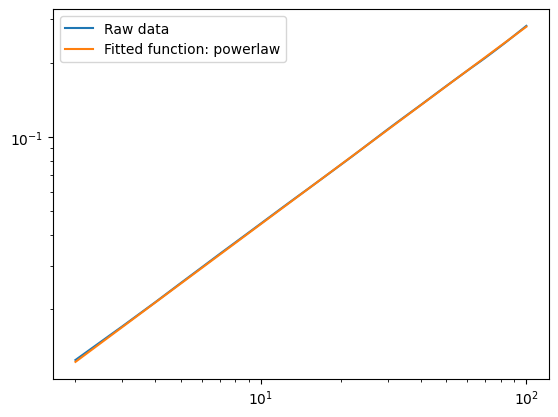

In [300]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = sign_imbalance_fit_objects[('TSLA', 'generalized', 'signed_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()

### 3.2. Signed Volume imbalance long memory

In [301]:
# Linear ACF
volume_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_linear_acfs.pkl"
volume_imbalance_linear_acfs = compute_acfs(filename=volume_imbalance_linear_acf_filename, data=volume_imbalance, option='linear')
print(volume_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [302]:
# Nonlinear ACF
volume_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_nonlinear_acfs.pkl"
volume_imbalance_nonlinear_acfs = compute_acfs(filename=volume_imbalance_nonlinear_acf_filename, data=volume_imbalance, option='nonlinear')
print(volume_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


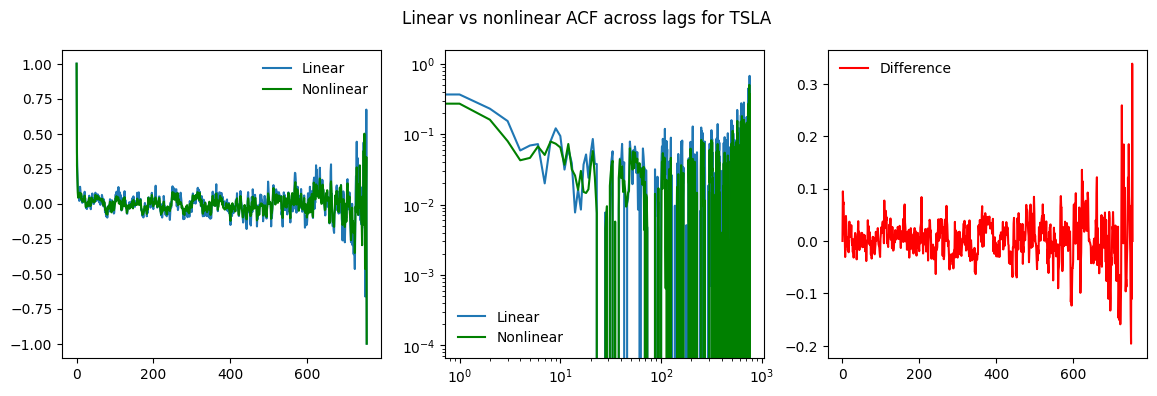

TSLA Max difference: 0.33857079971843773


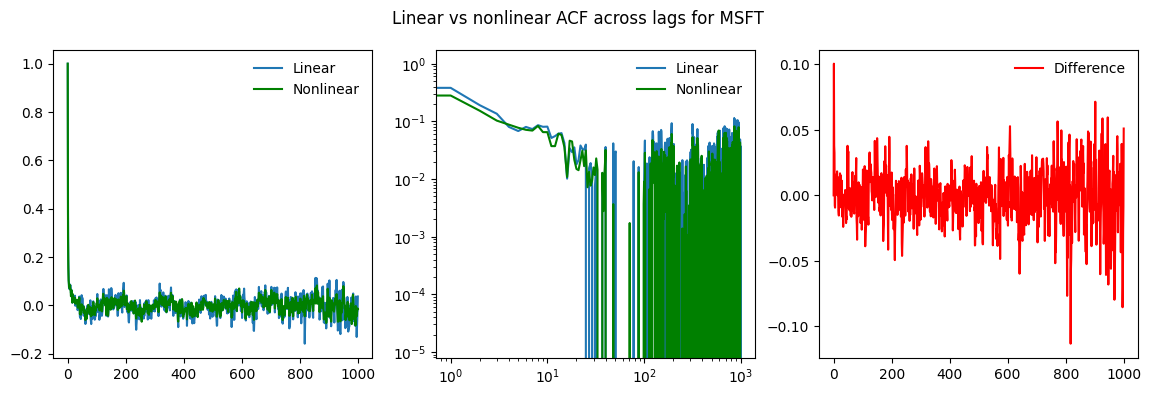

MSFT Max difference: 0.10059054831523123


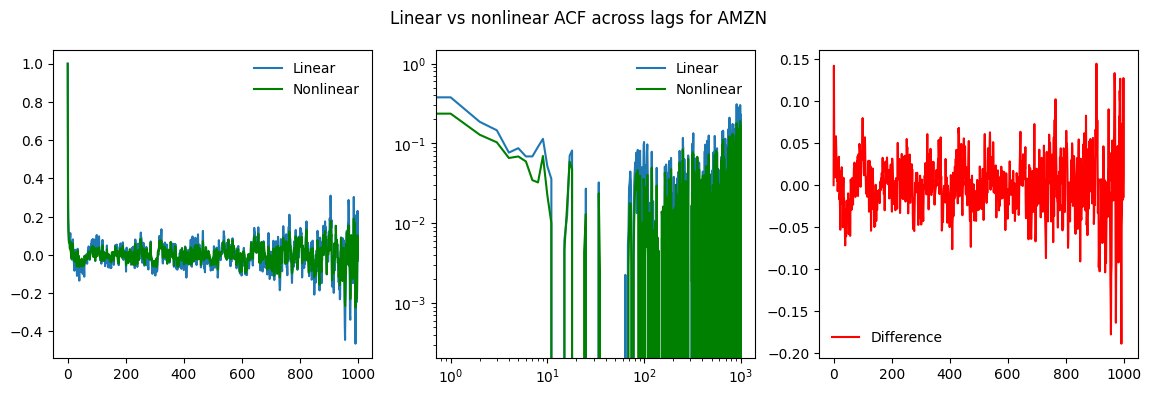

AMZN Max difference: 0.14451829005881364


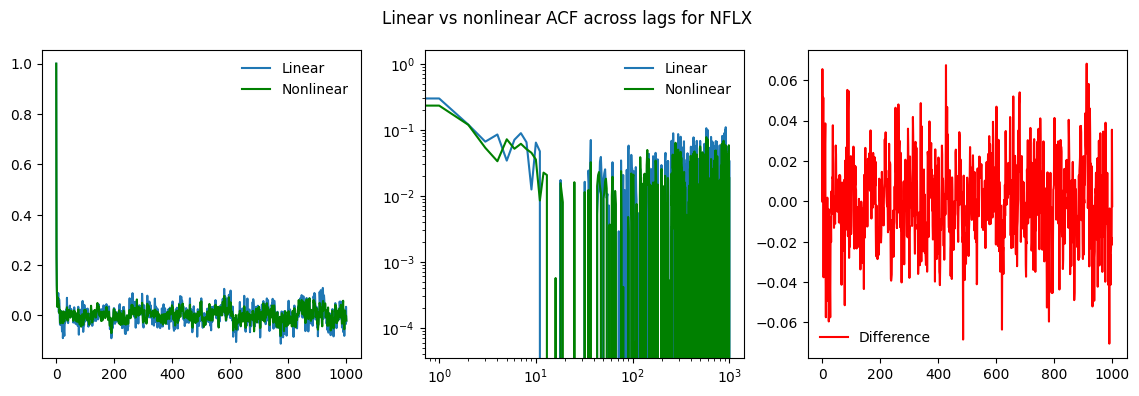

NFLX Max difference: 0.06818015388961857


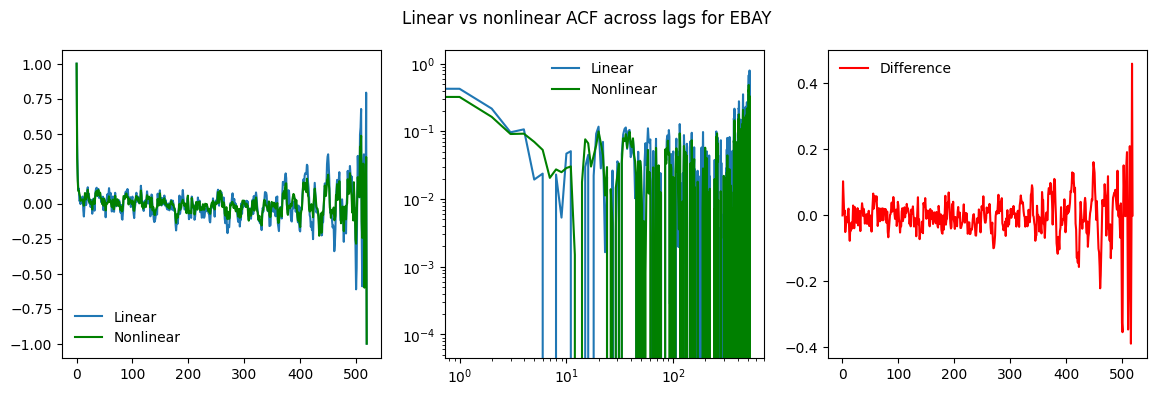

EBAY Max difference: 0.4596602076921763


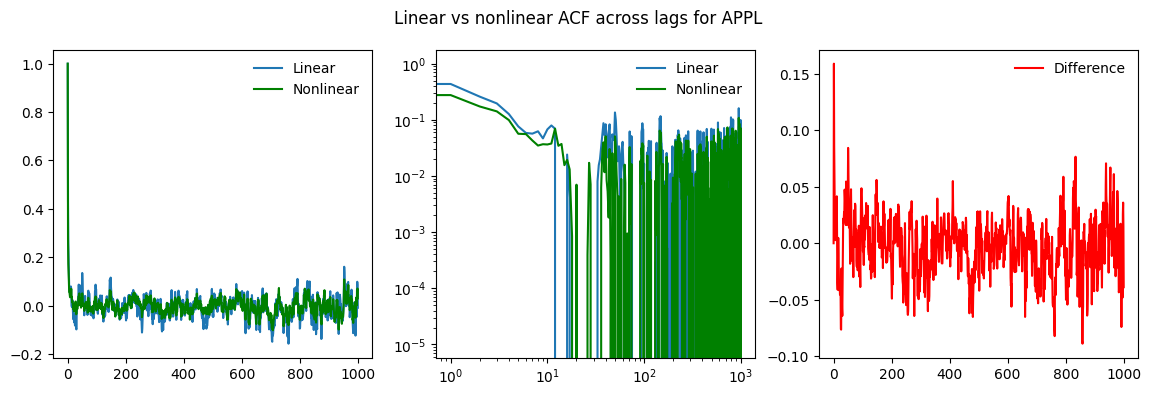

APPL Max difference: 0.1589996219815102


In [303]:
for stock_name in volume_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_imbalance_linear_acfs, volume_imbalance_nonlinear_acfs)

#### 3.2.1. Fit power law to ACF

In [304]:
# Load the pre-computed ACFs
volume_imbalance_acf_values = {}

for stock, data in volume_imbalance_nonlinear_acfs.items():
    volume_imbalance_acf_values[stock] = construct_xy(data, stock)

In [305]:
# Using signs_imbalance_nonlinear_acfs
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

volume_imbalance_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_fit_results.head())

cannot unpack non-iterable NoneType object
cannot unpack non-iterable NoneType object


/Users/ana_bugaenko/workspace/powerlaw_function/util/linear_fits.py:25: RuntimeWarning: divide by zero encountered in log
  log_y_values = np.log(y_values)
/Users/ana_bugaenko/workspace/powerlaw_function/util/supported_functions.py:25: RuntimeWarning: invalid value encountered in multiply
  return C * x**alpha
/Users/ana_bugaenko/workspace/powerlaw_function/util/linear_fits.py:25: RuntimeWarning: divide by zero encountered in log
  log_y_values = np.log(y_values)
/Users/ana_bugaenko/workspace/powerlaw_function/util/supported_functions.py:25: RuntimeWarning: invalid value encountered in multiply
  return C * x**alpha


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -5.539063...",10,12.0,0.475871,-3808.502426,inf,-0.001994,0.776955,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000823...",10,11.0,0.495459,-7239.563710,117.694803,-0.002732,0.164110,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.071374...",10,11.0,0.480323,-5910.107460,104.204379,-0.001677,-0.626130,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3423263...",10,11.0,0.481332,-7415.163051,115.779260,-0.001683,1.076640,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000160...",10,12.0,0.453831,-2394.086931,inf,-0.000728,0.720448,EBAY


In [306]:
print(volume_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [307]:
avg_alpha = volume_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: 0.4799220277979776


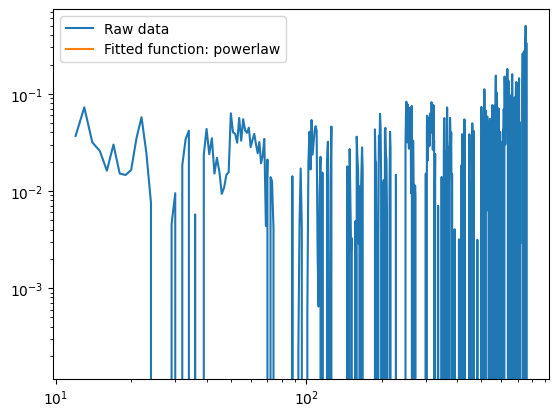

In [308]:
tsla_acf_fit = volume_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.2.2. Volume Imbalance Hurst Exponents

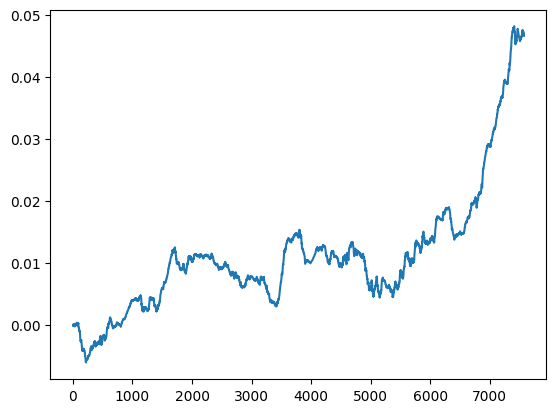

In [309]:
# Compute cumsum of order sign imbalance
cumsum_volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'].cumsum(),
 'MSFT': msft_aggregate_orderflow['vol_imbalance'].cumsum(),
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'].cumsum(),
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'].cumsum(),
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'].cumsum(),
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_volume_imbalance.items()}
tsla_cumsum_volume_imbalance = tsla_aggregate_orderflow['vol_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_volume_imbalance)+1))
plt.plot(x, tsla_cumsum_volume_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [310]:
# Standard Hurst
method = 'standard'
volume_imbalance_fit_results_list = []
voliume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        voliume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_std_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 9.4910205...",1,2.0,0.034884,-1717.993191,2.589625,0.994765,0.691162,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8375841...",1,1.0,0.040984,-3544.511432,1.760747,0.998270,0.685643,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.9779296...",1,2.0,0.030303,-2020.843410,2.023551,0.996124,0.690948,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.7057969...",1,1.0,0.031746,-2961.732468,1.985963,0.997039,0.649985,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 4.5939596...",1,2.0,0.042254,-1848.874368,3.344250,0.994205,0.678266,EBAY,volume_imbalance


In [311]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5689139307461707


##### Generalized Hurst

In [312]:
# Generalized Hurst
method = 'generalized'
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_gen_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.9027068...",1,2.0,0.011628,-2028.437553,1.297237,0.999764,0.704170,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1461254...",1,1.0,0.016393,-4016.641090,0.374970,0.999954,0.756983,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.5951787...",1,2.0,0.010101,-2557.271477,0.315180,0.999975,0.748076,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.7313667...",1,1.0,0.015873,-3395.130560,0.993440,0.999851,0.693225,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.3382886...",1,2.0,0.028169,-2000.280058,2.612399,0.998885,0.693263,EBAY,volume_imbalance


In [313]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.03710278064302332
Max Generalized Hurst: 0.7569830333492142
Average Generalized Hurst: 0.6054697629715667
Standard_dev Generalized Hurst: 0.2798156382624879


In [314]:
display(volume_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume_imbalance'), ('MSFT', 'generalized', 'volume_imbalance'), ('AMZN', 'generalized', 'volume_imbalance'), ('NFLX', 'generalized', 'volume_imbalance'), ('EBAY', 'generalized', 'volume_imbalance'), ('APPL', 'generalized', 'volume_imbalance')])

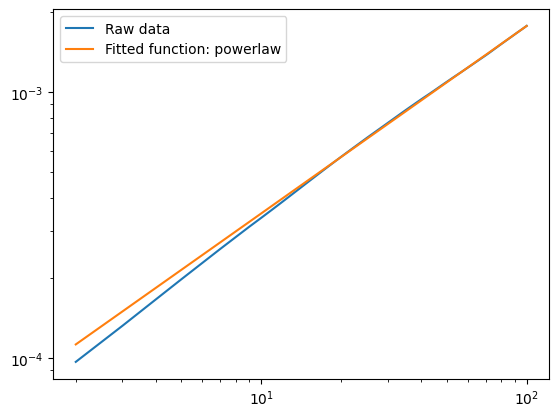

In [315]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = volume_imbalance_fit_objects[('TSLA', 'generalized', 'volume_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()